#  <center> Baby Emotion Recognition <center>

# Importing Libraries

In [13]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow
from IPython.display import Audio
from tensorflow import keras 
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from keras.utils import *
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ModuleNotFoundError: No module named 'keras.api'

In [ ]:
data = "DATA1.3just2label/"
paths=[]
labels=[]
for dirname,_,filenames in os.walk(data):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))
        label=filename.split('_')[0]
        #label=label.split('.')[0]
        labels.append(label.lower())
data_path=pd.DataFrame()
data_path['Emotions']=labels
data_path['Path']=paths
data_path

## Data Visualisation

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

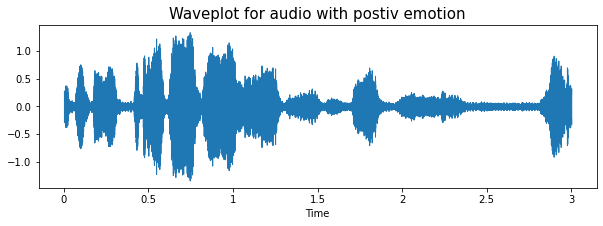

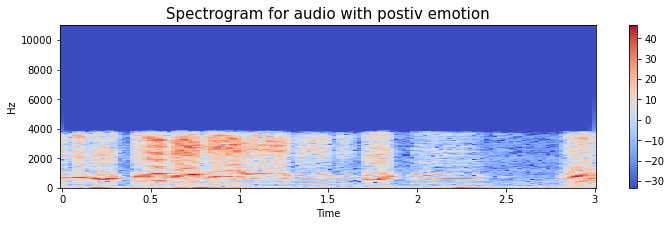

In [5]:
emotion='postiv'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

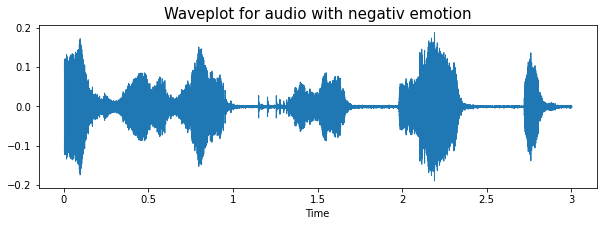

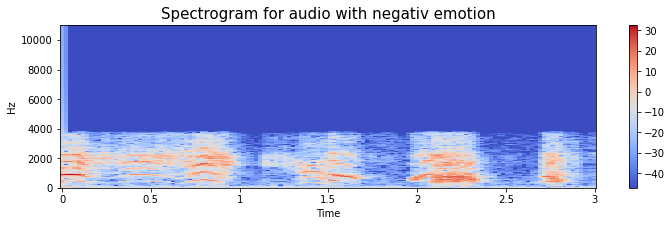

In [13]:
emotion='negativ'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [7]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

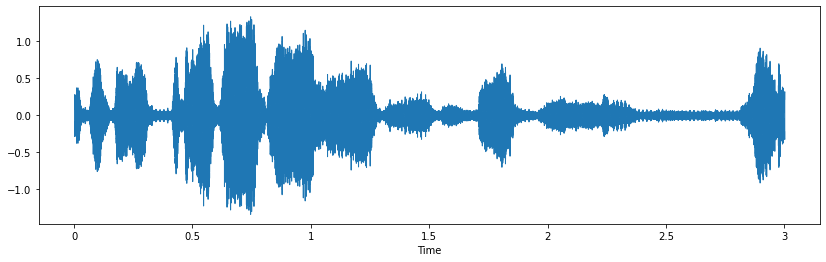

In [8]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

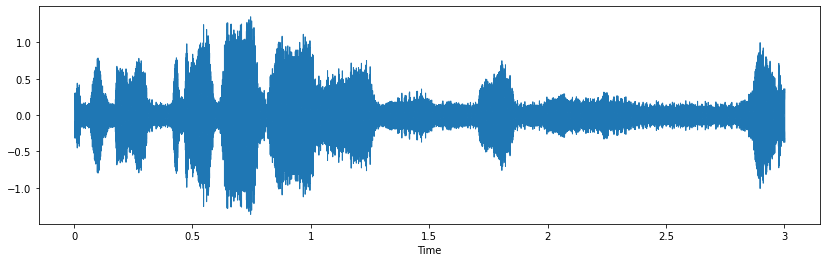

In [9]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

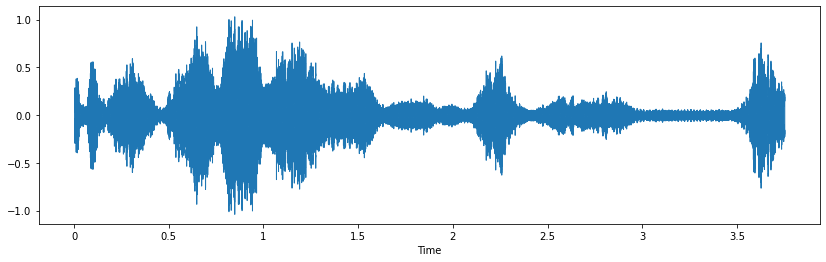

In [10]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

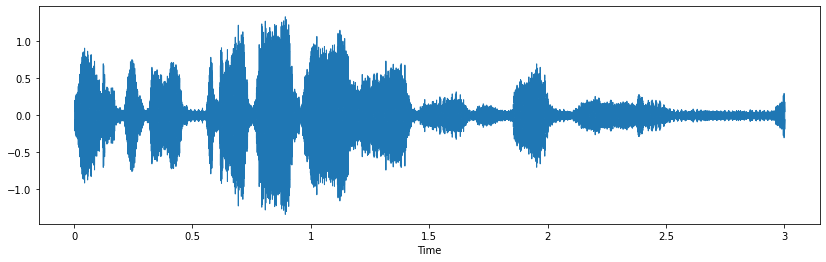

In [11]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

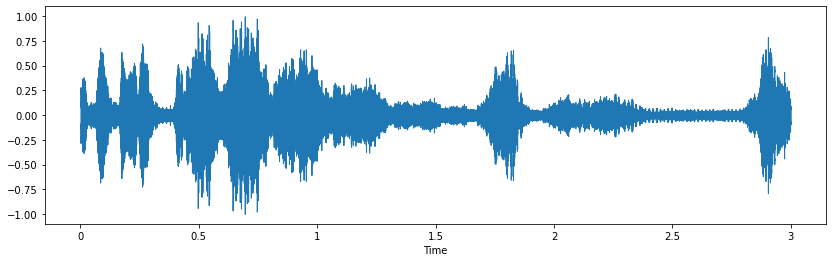

In [12]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

In [ ]:
def extract_features(data):
    result = np.array([])
#     # ZCR

#     zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
#     result=np.hstack((result, zcr)) 

    # Chroma_stft
#     stft = np.abs(librosa.stft(data))
#     chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
#     result = np.hstack((result, chroma_stft))

    # MFCC
#    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
#    result = np.hstack((result, mfcc)) 

#     # Root Mean Square Value
#     rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
#     result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) 
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('saved information/featuresofZCR.csv', index=False)
Features.head()

In [8]:
Features=pd.read_csv("saved information/featuresofZCR.csv")
Features.head()

,0,labels
0,0.040729,postiv
1,0.243056,postiv
2,0.044497,postiv
3,0.085604,postiv
4,0.223412,postiv


## Data Preparation

In [14]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [15]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.1, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1320, 20), (1320, 2), (147, 20), (147, 2))

In [17]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1320, 20), (1320, 2), (147, 20), (147, 2))

In [36]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1320, 20, 1), (1320, 2), (147, 20, 1), (147, 2))

## Modelling

In [37]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=2, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 20, 256)           1536      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 10, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 10, 256)           327936    
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 5, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 5, 128)            163968    
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 3, 128)          

In [38]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=200, epochs=60, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/60
7/7 [==============================] - 1s 92ms/step - loss: 0.6996 - accuracy: 0.4886 - val_loss: 0.7040 - val_accuracy: 0.4626 - lr: 0.0010
Epoch 2/60
7/7 [==============================] - 0s 37ms/step - loss: 0.6942 - accuracy: 0.5068 - val_loss: 0.6852 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 3/60
7/7 [==============================] - 0s 36ms/step - loss: 0.6829 - accuracy: 0.5242 - val_loss: 0.6621 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 4/60
7/7 [==============================] - 0s 36ms/step - loss: 0.6701 - accuracy: 0.5545 - val_loss: 0.6461 - val_accuracy: 0.6735 - lr: 0.0010
Epoch 5/60
7/7 [==============================] - 0s 37ms/step - loss: 0.6462 - accuracy: 0.6106 - val_loss: 0.5901 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 6/60
7/7 [==============================] - 0s 36ms/step - loss: 0.6130 - accuracy: 0.6409 - val_loss: 0.5140 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 7/60
7/7 [==============================] - 0s 37ms/step - loss: 0.5823 - accuracy

Epoch 54/60
7/7 [==============================] - 0s 36ms/step - loss: 0.1124 - accuracy: 0.9629 - val_loss: 0.1613 - val_accuracy: 0.9456 - lr: 1.6000e-04
Epoch 55/60
7/7 [==============================] - 0s 36ms/step - loss: 0.1248 - accuracy: 0.9568 - val_loss: 0.1732 - val_accuracy: 0.9388 - lr: 1.6000e-04
Epoch 56/60
7/7 [==============================] - 0s 36ms/step - loss: 0.1165 - accuracy: 0.9583 - val_loss: 0.1611 - val_accuracy: 0.9388 - lr: 1.6000e-04
Epoch 57/60
7/7 [==============================] - 0s 36ms/step - loss: 0.0979 - accuracy: 0.9720 - val_loss: 0.1659 - val_accuracy: 0.9388 - lr: 6.4000e-05
Epoch 58/60
7/7 [==============================] - 0s 41ms/step - loss: 0.0961 - accuracy: 0.9742 - val_loss: 0.1591 - val_accuracy: 0.9388 - lr: 6.4000e-05
Epoch 59/60
7/7 [==============================] - 0s 46ms/step - loss: 0.1016 - accuracy: 0.9735 - val_loss: 0.1695 - val_accuracy: 0.9388 - lr: 6.4000e-05
Epoch 60/60
7/7 [==============================] - 0s 46ms

5/5 [==============================] - 0s 17ms/step - loss: 0.1637 - accuracy: 0.9388
Accuracy of our model on test data :  93.87755393981934 %


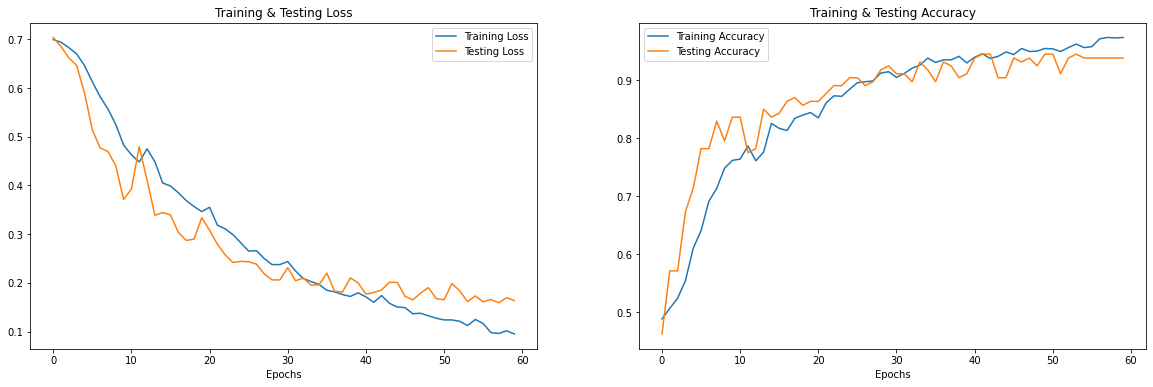

In [39]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [40]:
path1="happy_571.wav"
data1, sample_rate1 = librosa.load(path1, duration=2.5, offset=0.6)
testsample = np.mean(librosa.feature.mfcc(y=data1, sr=sample_rate1).T, axis=0)
testsample=np.expand_dims(testsample, axis=1)
testsample=np.expand_dims(testsample, axis=0)
p=model.predict(testsample)
print(encoder.inverse_transform(p))

1/1 [==============================] - 0s 126ms/step
[['postiv']]


In [41]:
x_test.shape

(147, 20, 1)

In [42]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)


5/5 [==============================] - 0s 15ms/step


In [43]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,postiv,postiv
1,negativ,negativ
2,negativ,negativ
3,negativ,negativ
4,negativ,negativ
5,negativ,negativ
6,negativ,negativ
7,postiv,postiv
8,negativ,negativ
9,postiv,postiv


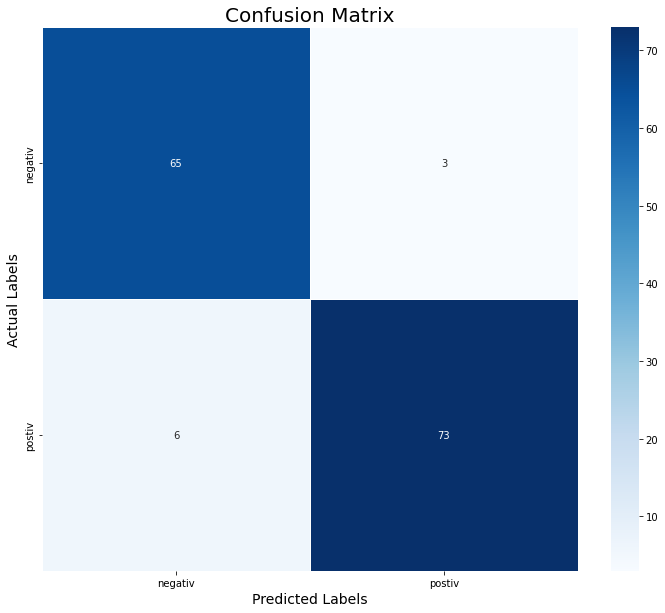

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     negativ       0.92      0.96      0.94        68
      postiv       0.96      0.92      0.94        79

    accuracy                           0.94       147
   macro avg       0.94      0.94      0.94       147
weighted avg       0.94      0.94      0.94       147



## LSTM

In [101]:
model1=Sequential([
    LSTM(64,return_sequences=False,input_shape=(x_train.shape[1], x_train.shape[2],)),
    Dense(32,activation='relu'),
    Dropout(0.2),
    Dense(32,activation='relu'),
    Dropout(0.2),

    Dense(2,activation='softmax')
])
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64)                16896     
                                                                 
 dense_71 (Dense)            (None, 32)                2080      
                                                                 
 dropout_47 (Dropout)        (None, 32)                0         
                                                                 
 dense_72 (Dense)            (None, 32)                1056      
                                                                 
 dropout_48 (Dropout)        (None, 32)                0         
                                                                 
 dense_73 (Dense)            (None, 2)                 66        
                                                                 
Total params: 20,098
Trainable params: 20,098
Non-tra

In [102]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=0, patience=2, min_lr=0.0000001)
historylstm=model1.fit(x_train, y_train, batch_size=5, epochs=70, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/70
264/264 [==============================] - 4s 9ms/step - loss: 0.6750 - accuracy: 0.5371 - val_loss: 0.6273 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/70
264/264 [==============================] - 2s 6ms/step - loss: 0.6264 - accuracy: 0.6356 - val_loss: 0.6126 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 3/70
264/264 [==============================] - 2s 6ms/step - loss: 0.6015 - accuracy: 0.6538 - val_loss: 0.5391 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 4/70
264/264 [==============================] - 3s 10ms/step - loss: 0.5841 - accuracy: 0.6735 - val_loss: 0.5547 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 5/70
264/264 [==============================] - 2s 7ms/step - loss: 0.5652 - accuracy: 0.6811 - val_loss: 0.4782 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 6/70
264/264 [==============================] - 2s 6ms/step - loss: 0.5648 - accuracy: 0.6909 - val_loss: 0.5098 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 7/70
264/264 [==============================] - 3s 11ms/step - 

5/5 [==============================] - 0s 11ms/step - loss: 0.1452 - accuracy: 0.9320
Accuracy of our model on test data :  93.19728016853333 %


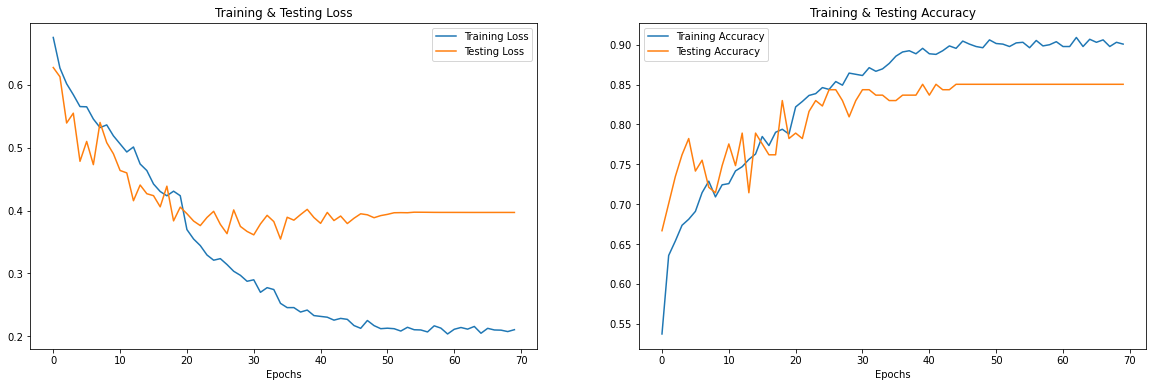

In [103]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(70)]
fig , ax = plt.subplots(1,2)
train_acc = historylstm.history['accuracy']
train_loss = historylstm.history['loss']
test_acc = historylstm.history['val_accuracy']
test_loss = historylstm.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()